In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

In [2]:
from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image



In [3]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

In [4]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print(np.degrees(angle), dist)
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [5]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print(i['angle'], i['dist'])
        
    return shortlisted_lines

In [6]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [7]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(10,7))
    fig.tight_layout()
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show()    

/home/gsunit/my-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  app.launch_new_instance()



All hough lines
90.0 2.5031605562578534
-27.653631284916205 112.6422250316055
14.581005586592168 51.565107458912735
28.659217877094957 234.7964601769911
78.93854748603351 328.91529709228814
56.815642458100555 306.88748419721867

Shorlisted lines
14.581005586592168 51.565107458912735


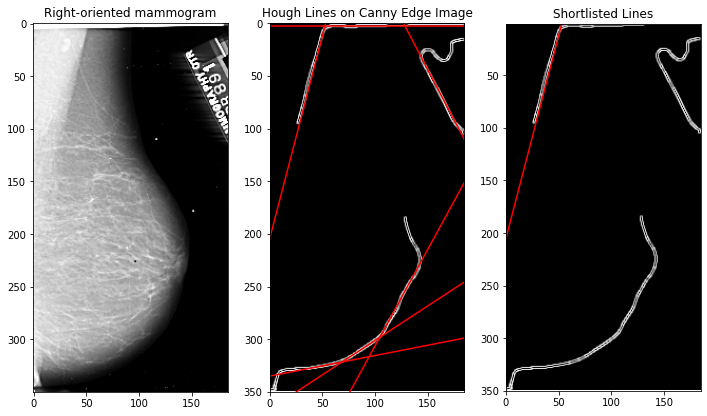

In [8]:
display_image('mammo_1.png')

/home/gsunit/my-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  app.launch_new_instance()



All hough lines
-22.625698324022345 33.542244640605304
30.67039106145251 114.6443883984868
-2.513966480446936 -8.510718789407292
82.9608938547486 305.88524590163934
26.64804469273743 231.79192938209337
1.5083798882681463 13.517023959646906
30.67039106145251 243.8070617906684
90.0 2.5031525851198353
-8.547486033519558 90.61412358133674

Shorlisted lines
30.67039106145251 114.6443883984868


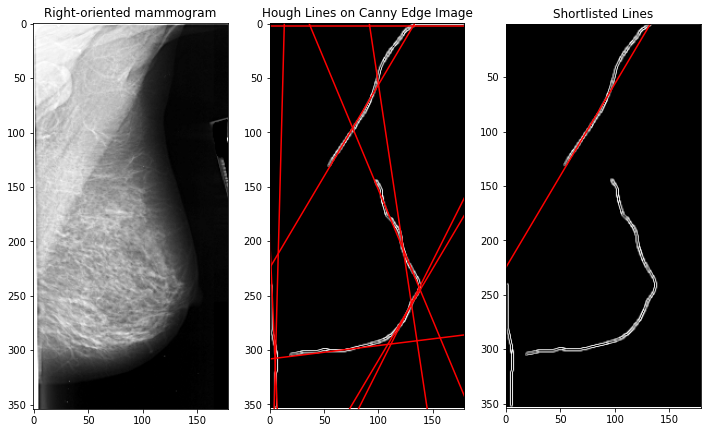

In [9]:
display_image('mammo_2.png')


All hough lines
90.0 2.503209242618709
17.597765363128488 47.5609756097561
49.77653631284915 240.808729139923
40.726256983240226 218.78048780487802
33.687150837988824 196.75224646983315
-7.541899441340782 55.57124518613608
-20.614525139664803 14.518613607188684
-3.5195530726257 69.58921694480102
-11.564245810055876 39.550706033376116

Shorlisted lines
17.597765363128488 47.5609756097561
33.687150837988824 196.75224646983315


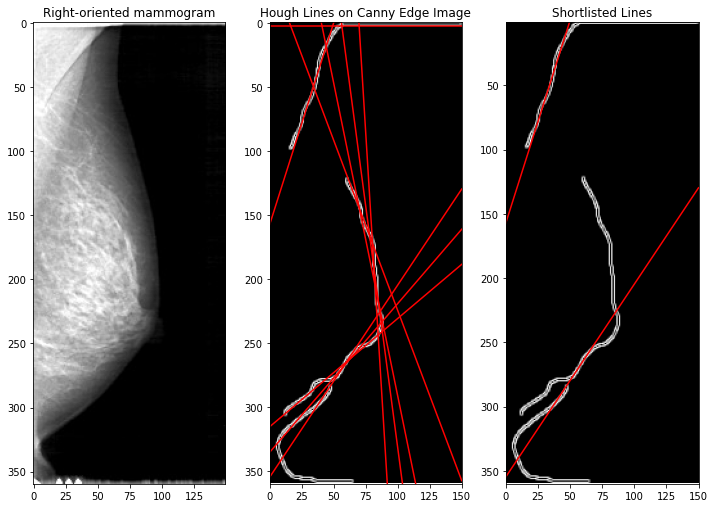

In [10]:
display_image('mammo_3.jpg')


All hough lines
25.642458100558663 78.60129032258061

Shorlisted lines
25.642458100558663 78.60129032258061


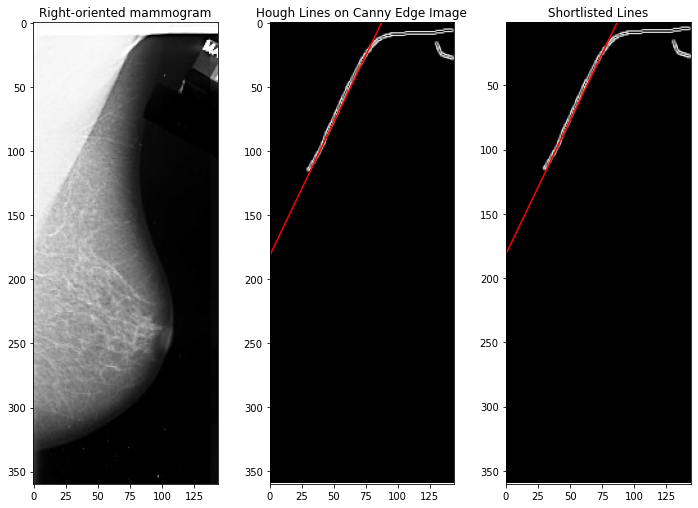

In [11]:
display_image('mammo_4.jpg')


All hough lines
0.5027932960893821 5.507304116865896
23.63128491620111 61.58167330677293
-44.74860335195531 -13.517928286852566

Shorlisted lines
23.63128491620111 61.58167330677293


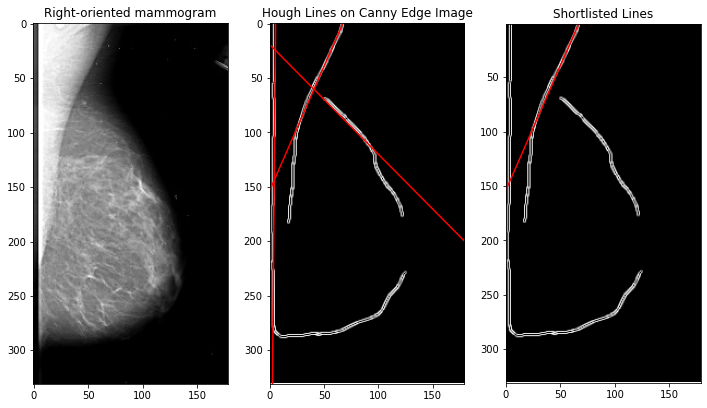

In [12]:
display_image('mammo_5.jpg')